In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


try:
    from image_classification import data_setup, engine, utils
except:
    print("[INFO] Couldn't find image_classification scripts... downloading them from GitHub.")
    !git clone https://github.com/regsah/TorchBox/
    !mv TorchBox/image_classification .
    !rm -rf TorchBox
    from image_classification import data_setup, engine, utils

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find image_classification scripts... downloading them from GitHub.
Cloning into 'TorchBox'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 64 (delta 20), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 16.35 MiB | 8.82 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data/")
image_path = data_path / "vegetables"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Unzip feline data
    with zipfile.ZipFile(data_path / "vegetable_data.zip", "r") as zip_ref:
        print("Unzipping vegetable data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "vegetable_data.zip")

data/vegetables directory exists.


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
validation_dir = image_path / "validation"

In [6]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=64)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e0247633b50>,
 ['Bean',
  'Bitter_Gourd',
  'Bottle_Gourd',
  'Brinjal',
  'Broccoli',
  'Cabbage',
  'Capsicum',
  'Carrot',
  'Cauliflower',
  'Cucumber',
  'Papaya',
  'Potato',
  'Pumpkin',
  'Radish',
  'Tomato'])

In [16]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [17]:
for param in model.features.parameters():
    param.requires_grad = False

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5013 | train_acc: 0.9338 | test_loss: 0.0937 | test_acc: 0.9930
Epoch: 2 | train_loss: 0.0990 | train_acc: 0.9873 | test_loss: 0.0416 | test_acc: 0.9973
Epoch: 3 | train_loss: 0.0607 | train_acc: 0.9927 | test_loss: 0.0259 | test_acc: 0.9977
Epoch: 4 | train_loss: 0.0437 | train_acc: 0.9943 | test_loss: 0.0209 | test_acc: 0.9987
Epoch: 5 | train_loss: 0.0321 | train_acc: 0.9962 | test_loss: 0.0153 | test_acc: 0.9987
[INFO] Total training time: 378.083 seconds


/content/image_classification/utils.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


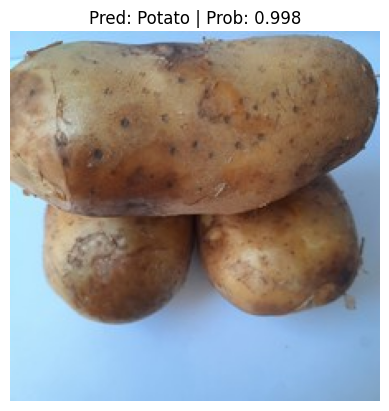

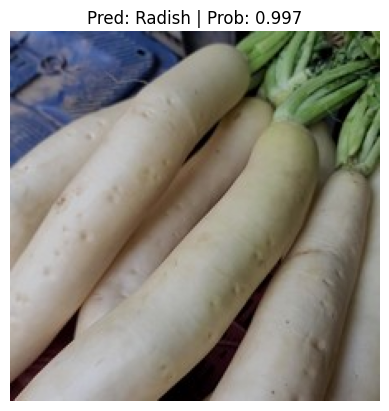

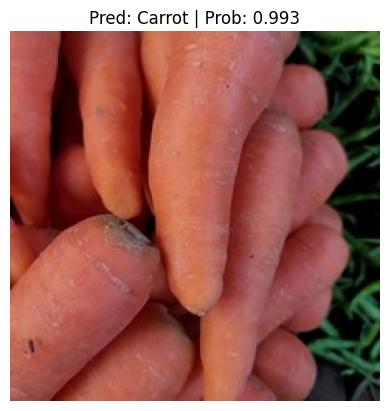

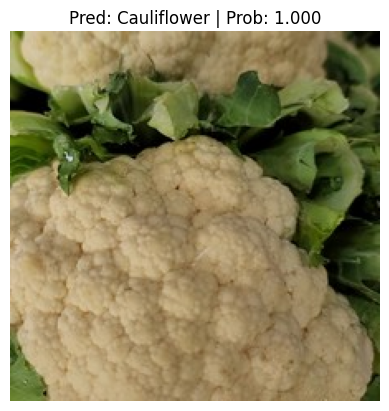

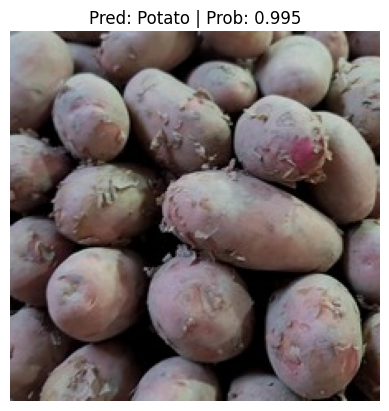

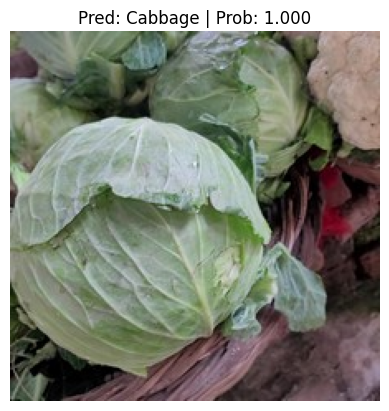

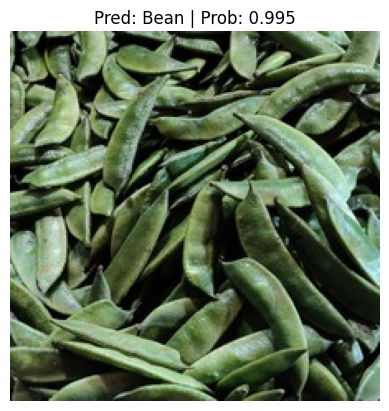

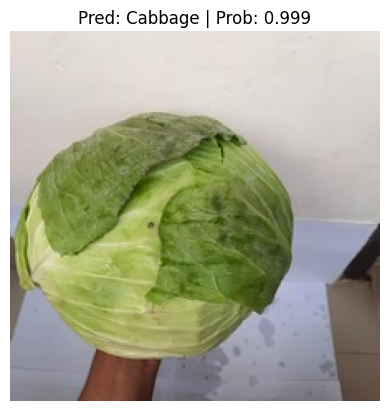

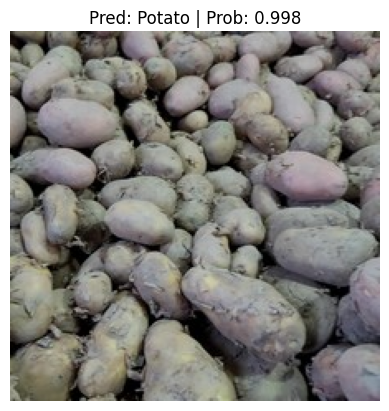

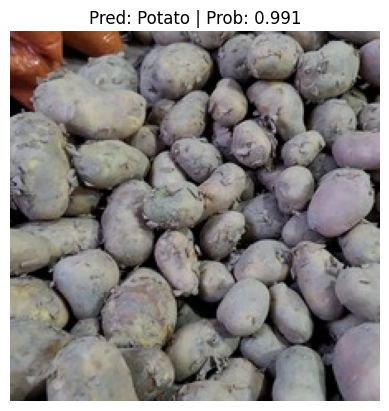

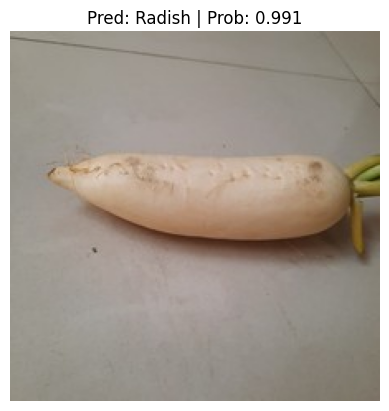

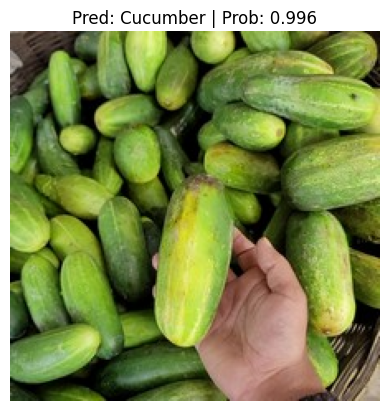

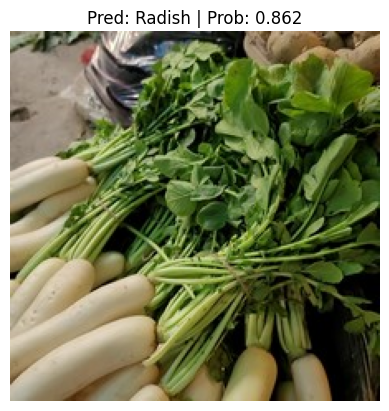

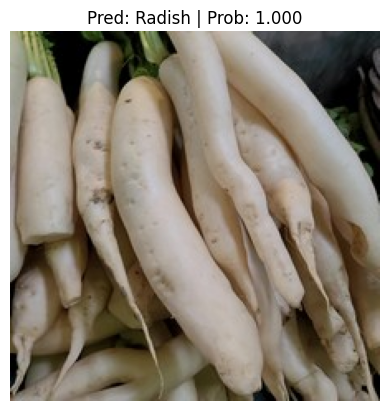

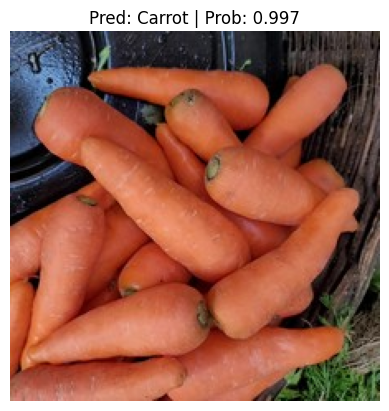

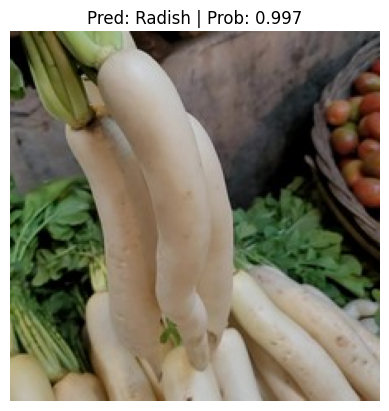

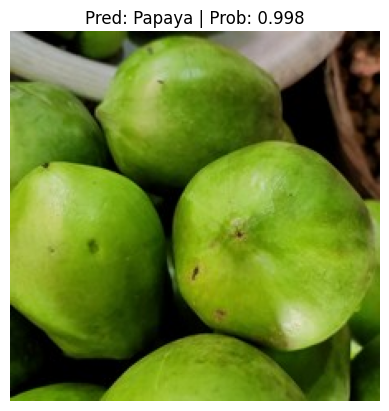

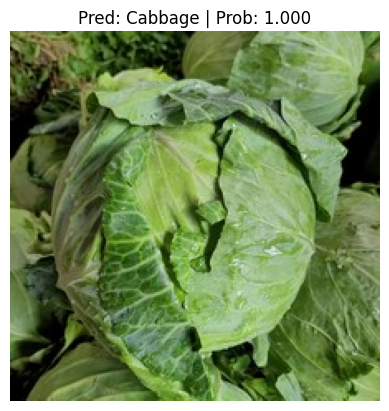

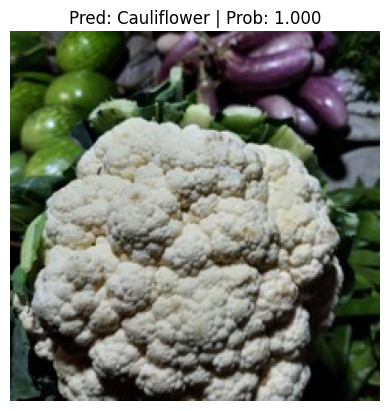

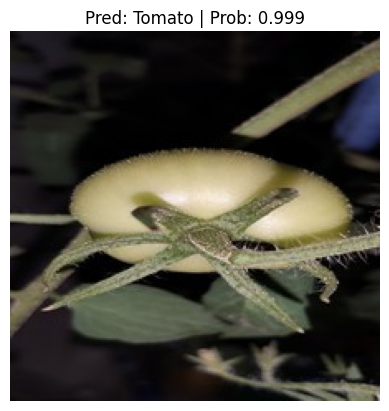

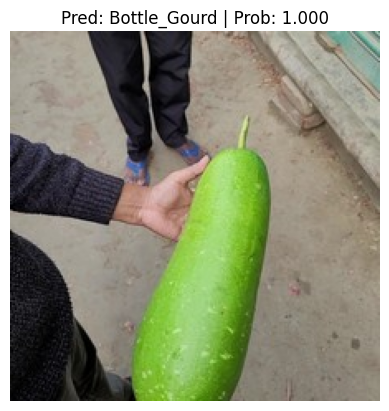

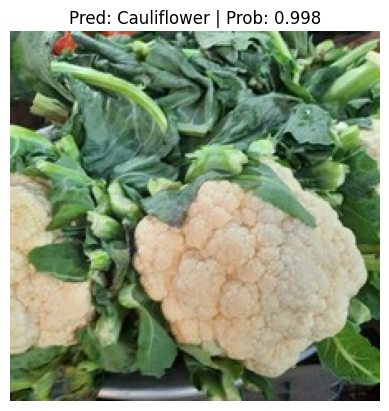

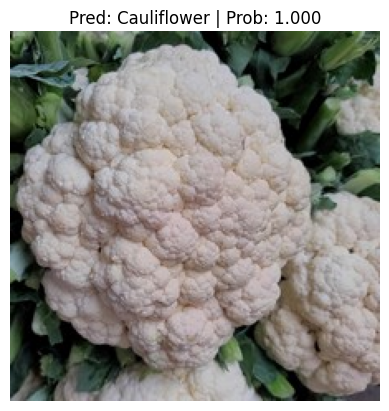

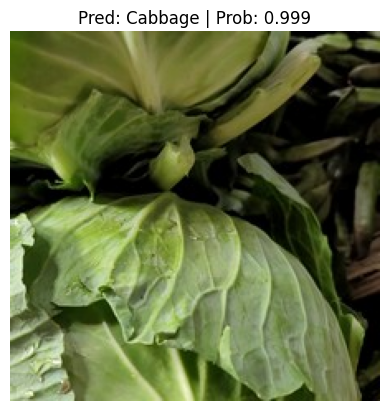

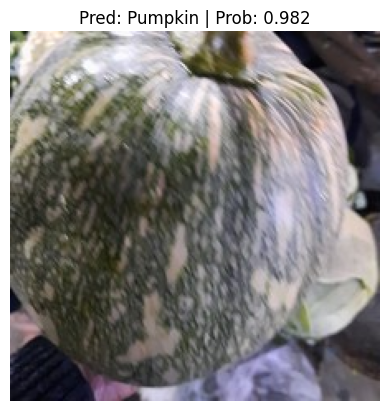

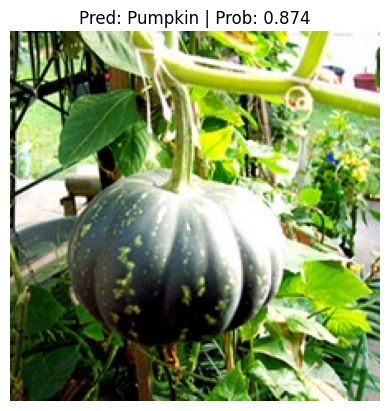

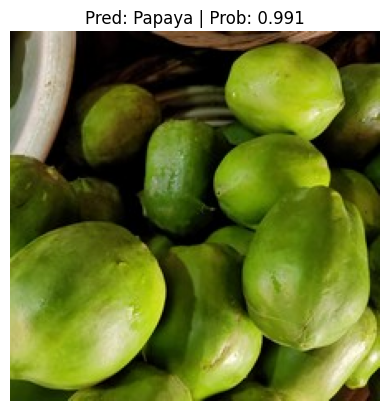

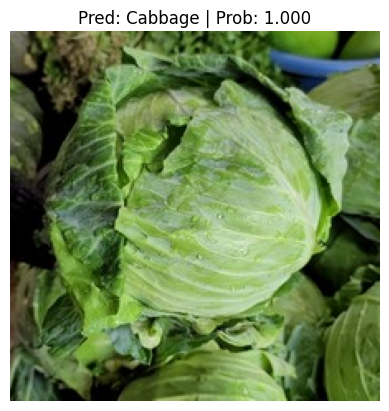

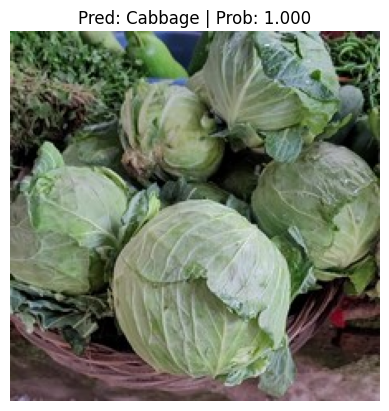

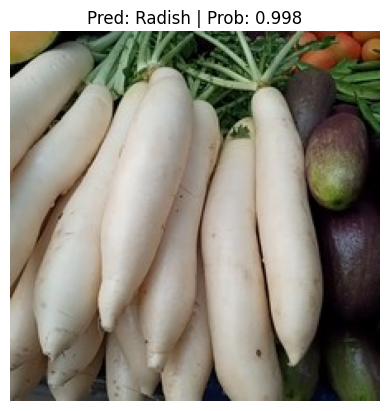

In [23]:
import random
num_images_to_plot = 30
validation_image_path_list = list(Path(validation_dir).glob("*/*.jpg"))
validation_image_path_sample = random.sample(population=validation_image_path_list,
                                       k=num_images_to_plot)

for image_path in validation_image_path_sample:
    utils.pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))